In [12]:
!pip install scikit-learn
!pip install pandas


In [13]:

from sklearn.preprocessing import LabelEncoder
import pandas as pd #import pandas library for reading CSV

# Load dataset
training_data = pd.read_csv('./Datasets/wildfires_training.csv')
test_data = pd.read_csv('./Datasets/wildfires_test.csv')
# Check to see if csv is loaded correctly
print(training_data.head())
print(test_data.head()) 

# Check to make sure test and training data have the same feature set.
training_first_row = training_data.iloc[0]  # Get the first row of the training dataset
test_first_row = test_data.iloc[0]          # Get the first row of the test dataset

# Assert that the first rows are equal
assert list(training_data.drop('fire', axis=1).columns) == list(test_data.drop('fire', axis=1).columns)


  fire  year  temp  humidity  rainfall  drought_code  buildup_index  day  \
0   no  2015    28        59       0.0          8.06           3.47    1   
1   no  2010    30        61       1.3          8.17           4.03    2   
2   no  2009    26        83      13.1          8.08           3.59    3   
3   no  2017    25        87       2.5          7.18           2.42    4   
4   no  2014    28        77       0.0         14.98           4.63    5   

   month  wind_speed  
0      6          19  
1      6          13  
2      6          22  
3      6          15  
4      6          18  
  fire  year  temp  humidity  rainfall  drought_code  buildup_index  day  \
0   no  2015    33        68       4.5          9.12           5.09   19   
1  yes  2009    28        56       0.0         38.17          21.21   12   
2   no  2017    30        64       0.6         15.38           6.24   24   
3   no  2007    23        74       8.3          7.36           2.27   14   
4   no  2017    31       

In [14]:
X_training = training_data.drop('fire', axis=1)  # Features (everything except "fire")
y_training = training_data['fire']   
print(X_training.head())  
print(y_training.head())           # Target variable (What I want to predict "fire" column)

   year  temp  humidity  rainfall  drought_code  buildup_index  day  month  \
0  2015    28        59       0.0          8.06           3.47    1      6   
1  2010    30        61       1.3          8.17           4.03    2      6   
2  2009    26        83      13.1          8.08           3.59    3      6   
3  2017    25        87       2.5          7.18           2.42    4      6   
4  2014    28        77       0.0         14.98           4.63    5      6   

   wind_speed  
0          19  
1          13  
2          22  
3          15  
4          18  
0    no
1    no
2    no
3    no
4    no
Name: fire, dtype: object


In [15]:

X_test = test_data.drop('fire', axis=1)  # Featuåres (everything except "fire")
y_test = test_data['fire']               # Target variable (What I want to predict "fire" column)
print(X_test.head())
print(y_test.head())  

   year  temp  humidity  rainfall  drought_code  buildup_index  day  month  \
0  2015    33        68       4.5          9.12           5.09   19      6   
1  2009    28        56       0.0         38.17          21.21   12      6   
2  2017    30        64       0.6         15.38           6.24   24      9   
3  2007    23        74       8.3          7.36           2.27   14      9   
4  2017    31        72       0.3         30.47           5.63    7      9   

   wind_speed  
0          16  
1          18  
2          19  
3          28  
4          17  
0     no
1    yes
2     no
3     no
4     no
Name: fire, dtype: object


In [16]:
# Entropy of the indepednent variable 
from scipy.stats import entropy
print(y_training.value_counts(normalize=True))  # Training data
training_entropy = entropy(y_training.value_counts(normalize=True), base=2)
print(f"Entropy of training data: {training_entropy}")

fire
yes    0.512987
no     0.487013
Name: proportion, dtype: float64
Entropy of training data: 0.9995132881417702


In [17]:
# Model fitting and accuracy evaluation
from sklearn.ensemble import HistGradientBoostingClassifier

#Model with default settings
hbgc_model = HistGradientBoostingClassifier()
hbgc_model.fit(X_training, y_training)

#Compute accuracy on the training predictions
hbgc_model.predict(X_training)
accuracy = hbgc_model.score(X_training, y_training)

print("Accuracy on training dataset provided:", accuracy)

Accuracy on training dataset provided: 1.0


In [18]:
#Compute accuracy on the training predictions without fine tuning
hbgc_model.predict(X_test)
accuracy = hbgc_model.score(X_test, y_test)

print("Accuracy on test dataset provided:", accuracy)

Accuracy on test dataset provided: 0.84


# Model Hyperparameter Fine Tuning

Fitting 3 folds for each of 304 candidates, totalling 912 fits
[CV] END .............learning_rate=0.05, min_samples_leaf=7; total time=   0.2s
[CV] END .............learning_rate=0.05, min_samples_leaf=9; total time=   0.2s
[CV] END .............learning_rate=0.05, min_samples_leaf=7; total time=   0.3s
[CV] END .............learning_rate=0.05, min_samples_leaf=9; total time=   0.2s
[CV] END .............learning_rate=0.05, min_samples_leaf=7; total time=   0.3s
[CV] END .............learning_rate=0.05, min_samples_leaf=5; total time=   0.3s
[CV] END .............learning_rate=0.05, min_samples_leaf=5; total time=   0.3s
[CV] END .............learning_rate=0.05, min_samples_leaf=5; total time=   0.3s
[CV] END ............learning_rate=0.05, min_samples_leaf=11; total time=   0.1s
[CV] END ............learning_rate=0.05, min_samples_leaf=11; total time=   0.1s
[CV] END ............learning_rate=0.05, min_samples_leaf=11; total time=   0.1s
[CV] END .............learning_rate=0.05, min_

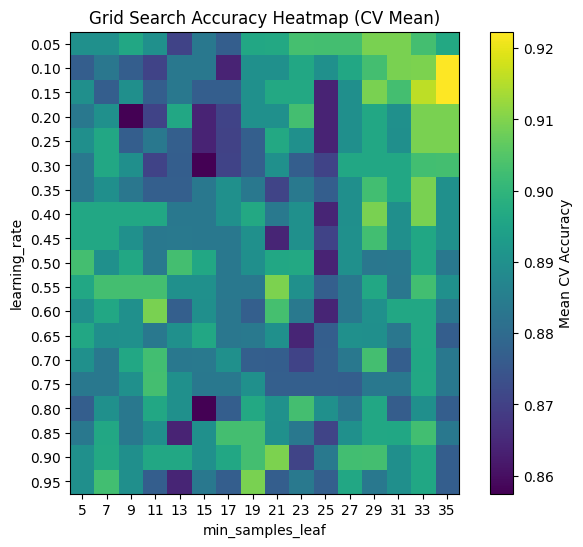

In [30]:
# Efficient Hyperparameter Search for HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Define parameter grid (smaller and realistic to start)
param_grid = {
    'learning_rate': np.arange(0.05, 0.99, 0.05),  # 0.05 to 0.5
    'min_samples_leaf': range(5, 37, 2)            # 5, 10, 15, 20, 25, 30
}

# 2️⃣ Initialize model
hgbc = HistGradientBoostingClassifier(random_state=42)

# 3️⃣ Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=hgbc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,              # 3-fold cross-validation
    n_jobs=-1,         # use all CPU cores
    verbose=2          # show progress in console
)

# 4️⃣ Run grid search on training data
grid_search.fit(X_training, y_training)

# 5️⃣ Best parameters and scores
print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# 6️⃣ Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print("\nTest Set Accuracy:", test_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 7️⃣ (Optional) Visualize accuracy heatmap
results = grid_search.cv_results_
scores = results['mean_test_score']

# reshape for heatmap
lr_values = param_grid['learning_rate']
msl_values = param_grid['min_samples_leaf']
scores_matrix = np.array(scores).reshape(len(lr_values), len(msl_values))

plt.figure(figsize=(8, 6))
plt.imshow(scores_matrix, interpolation='nearest', cmap='viridis')
plt.colorbar(label='Mean CV Accuracy')
plt.xticks(np.arange(len(msl_values)), msl_values)
plt.yticks(np.arange(len(lr_values)), [f"{lr:.2f}" for lr in lr_values])
plt.xlabel('min_samples_leaf')
plt.ylabel('learning_rate')
plt.title('Grid Search Accuracy Heatmap (CV Mean)')
plt.show()


In [40]:
hbgc_model = HistGradientBoostingClassifier(learning_rate = 0.8300000000000001, min_samples_leaf=31)
hbgc_model.fit(X_training, y_training)
hbgc_model.predict(X_training)
accuracy = hbgc_model.score(X_training, y_training)
print("Accuracy on training dataset provided:", accuracy)

Accuracy on training dataset provided: 1.0


In [41]:
hbgc_model.predict(X_test)
accuracy = hbgc_model.score(X_test, y_test)

print("Accuracy on test dataset with learning_rate provided:", accuracy)
print(classification_report(y_test, hbgc_model.predict(X_test)))

Accuracy on test dataset with learning_rate provided: 0.92
              precision    recall  f1-score   support

          no       0.88      0.95      0.91        22
         yes       0.96      0.89      0.93        28

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50

